In [1]:
import os
import time
import altair as alt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gif
import ipywidgets as widgets
from ipywidgets import interact
import sys; sys.path.insert(0, '..')
import trajectory_reconstruction_tradeoff as T
# from scipy.sparse.csgraph import dijkstra
# from trees.prosst_tree import get_test_tree
# from trees.process_tree import subsample_tree, preprocess

# from tools.compute_dists import get_pairwise_distances


In [2]:
def get_path(src, des, P):
    # Traces the cell path between two indices
    path = []
    while (des != src) & (des>=0):
        path.append(des)
        des = P[src][des]

    path.append(src)
    return path



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


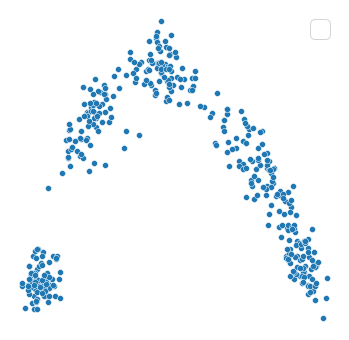

In [3]:
# read trajectory
dirname = '/cs/labs/mornitzan/nomoriel/trajectory_reconstruction_tradeoff/'
datadir = os.path.join(dirname, 'datasets')
outdir = os.path.join(dirname, 'output_new2' )

dataset = 'hayashi' #'hematopoiesis'#  #'hayashi' # 'linear_rep0' #'hematopoiesis' #  #'fibroblasts'#'hepatoblast' #
X,_, meta = T.io.read_dataset(dataset, datadir)
traj = T.tr.Trajectory(X, meta=meta)
T.pl.plot_pca2d(traj.pX)

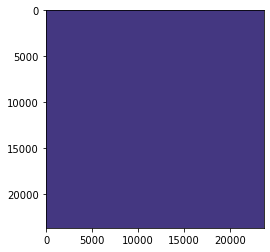

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


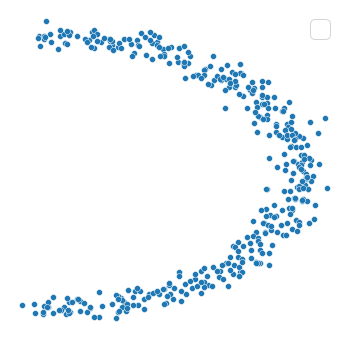

In [15]:
# nc = 400
# scale_noise = 5
# R = 100
# frac_curve = 1
# p_in_k = 0.5
# dims=10

# dataset = 'curve_simul'
# pX = T.io.curve_trajectory(nc=nc, frac_curve=frac_curve, R=R, scale_noise=scale_noise, dims=dims)

# # dataset = 'curve_cluster_simul'
# # pX = T.io.curve_clusters_trajectory(nc=nc, p_in_k=p_in_k, R=R, scale_noise=scale_noise, dims=dims)

# traj = T.tr.Trajectory(pX, do_preprocess=False, do_original_locs=True)
# T.pl.plot_pca2d(traj.pX)

In [ ]:
# L = traj.compute_tradeoff(B=0.1, Pc=[0.5], Pt=[1], repeats=1, comp_deltas=True)

In [ ]:
# T.pl.plot_pca2d(traj.pX.values)
# T.pl.plot_pca2d(psX.values)

## Read downsampling

In [10]:
## video pt
Pt = Pvar = 10 ** np.arange(-6, -0.5, 0.25)
Pc = np.ones_like(Pt)
repeat = 2

res_pt = []
res_path_max_dist = {}
for pt,pc in zip(Pt, Pc):
    # for r in np.arange(repeat):
    sX, psX, psD, sD, psP, ix = traj.subsample(pc,pt)

    D, P = T.ds.get_pairwise_distances(psX, return_predecessors=True)

    src,des = np.unravel_index(D.argmax(), D.shape)
    path_max_dist = get_path(src, des, P)
    res_path_max_dist[pt] = path_max_dist
    
    df = psX[['PC1', 'PC2']]
    df['pc'] = pc
    df['pt'] = pt
    df['idx_c'] = ix
    df['idx'] = np.arange(len(ix))
    # df['repeat'] = r
    res_pt.append(df)

/tmp/ipykernel_27917/2083720411.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pc'] = pc
/tmp/ipykernel_27917/2083720411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pt'] = pt
/tmp/ipykernel_27917/2083720411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [ ]:
# df_res_pt = pd.concat(res_pt)
df_pt = pd.concat(res_pt)

# grp_res_pt = df_res_pt.groupby(['pt', 'pc', 'idx_c', 'idx'])['pc0', 'pc1']

# mean_res_pt = grp_res_pt.mean()
# std_res_pt = grp_res_pt.std()

# mean_res_pt.reset_index(inplace=True)
# std_res_pt.reset_index(inplace=True)

# df_pt = pd.concat((mean_res_pt, std_res_pt[['pc0', 'pc1']].rename(columns={'pc0':'pc0 std', 'pc1':'pc1 std'})), axis=1)
# df_pt['std'] = df_pt[['pc0 std', 'pc1 std']].mean(1)

xlim = (df_pt['pc0'].min(), df_pt['pc0'].max())
ylim = (df_pt['pc1'].min(), df_pt['pc1'].max())

@gif.frame
def plot(j):
    i = len(Pt) - 1 - j
    sdf_pt = df_pt[df_pt['pt'] == Pt[i]]
    plt.scatter(sdf_pt['pc0'], sdf_pt['pc1'], c= sdf_pt['idx_c'], cmap='rainbow')
    # plt.scatter(sdf_pt['pc0'], sdf_pt['pc1'], c='r', alpha=0.1) # s=sdf_pt['std'],

    # sdf_pt.index = sdf_pt['idx']
    # sdf = sdf_pt.loc[res_path_max_dist[Pt[i]]]
    # sdf['path_idx'] = np.arange(sdf.shape[0])
    # plt.plot(sdf['pc0'], sdf['pc1'], c='r')

    plt.title(fr'log $p_t$={np.round(np.log(Pt[i]), 2)}')
    plt.axis('off')
    plt.xlim(xlim)
    plt.ylim(ylim)
    
frames = []
for j in range(len(Pt)):
    frame = plot(j)
    frames.append(frame)

gif.save(frames, f'{dataset}_pt_const_size.gif', duration=10, unit="s", between="startend")
# gif.save(frames, f'{dataset}_pt.gif', duration=10, unit="s", between="startend")
# gif.save(frames, 'Pt_const_size.gif', duration=3.5, unit="s", between="startend")

In [ ]:
@gif.frame
def plot(j):
    i = len(Pt) - 1 - j
    sdf_pt = df_pt[df_pt['pt'] == Pt[i]]
    plt.scatter(sdf_pt['pc0'], sdf_pt['pc1'], c= sdf_pt['idx_c'], cmap='rainbow')
    # plt.scatter(sdf_pt['pc0'], sdf_pt['pc1'], c='r', alpha=0.1) # s=sdf_pt['std'],

    # sdf_pt.index = sdf_pt['idx']
    # sdf = sdf_pt.loc[res_path_max_dist[Pt[i]]]
    # sdf['path_idx'] = np.arange(sdf.shape[0])
    # plt.plot(sdf['pc0'], sdf['pc1'], c='r')

    plt.title(fr'log $p_t$={np.round(np.log(Pt[i]), 2)}')
    plt.axis('off')
    
frames = []
for j in range(len(Pt)):
    frame = plot(j)
    frames.append(frame)

gif.save(frames, f'{dataset}_pt.gif', duration=10, unit="s", between="startend")

## Cell downsampling

Running with 3 neighbors


/tmp/ipykernel_18267/288266361.py:36: RuntimeWarning: invalid value encountered in true_divide
  l_contrac = (sD / psD)[np.triu_indices_from(sD, 1)]
/tmp/ipykernel_18267/288266361.py:37: RuntimeWarning: invalid value encountered in true_divide
  l_expand = (psD / sD)[np.triu_indices_from(sD, 1)]
/cs/usr/nomoriel/miniconda3/envs/traj/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/cs/usr/nomoriel/miniconda3/envs/traj/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level f

Empirical error: 2.7656046557155105
Quantized error: 1.2675688005362755
Error computed with modeled distance distribution: 1.8987322248319818
Running with 4 neighbors
Empirical error: 1.6127700337764788
Quantized error: 0.7775855519993737
Error computed with modeled distance distribution: 1.2806996917023585


/tmp/ipykernel_18267/288266361.py:36: RuntimeWarning: invalid value encountered in true_divide
  l_contrac = (sD / psD)[np.triu_indices_from(sD, 1)]
/tmp/ipykernel_18267/288266361.py:37: RuntimeWarning: invalid value encountered in true_divide
  l_expand = (psD / sD)[np.triu_indices_from(sD, 1)]
/cs/usr/nomoriel/miniconda3/envs/traj/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/cs/usr/nomoriel/miniconda3/envs/traj/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level f

Running with 4 neighbors
Empirical error: 2.0261106814270478
Quantized error: 0.9977060173693796
Error computed with modeled distance distribution: 2.0303720320311154


/tmp/ipykernel_18267/288266361.py:36: RuntimeWarning: invalid value encountered in true_divide
  l_contrac = (sD / psD)[np.triu_indices_from(sD, 1)]
/tmp/ipykernel_18267/288266361.py:37: RuntimeWarning: invalid value encountered in true_divide
  l_expand = (psD / sD)[np.triu_indices_from(sD, 1)]
/cs/usr/nomoriel/miniconda3/envs/traj/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/cs/usr/nomoriel/miniconda3/envs/traj/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level f

Running with 10 neighbors
Empirical error: 1.2487039259001704
Quantized error: 0.6201616813195479


/tmp/ipykernel_18267/288266361.py:36: RuntimeWarning: invalid value encountered in true_divide
  l_contrac = (sD / psD)[np.triu_indices_from(sD, 1)]
/tmp/ipykernel_18267/288266361.py:37: RuntimeWarning: invalid value encountered in true_divide
  l_expand = (psD / sD)[np.triu_indices_from(sD, 1)]
/cs/usr/nomoriel/miniconda3/envs/traj/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/cs/usr/nomoriel/miniconda3/envs/traj/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level f

Error computed with modeled distance distribution: 1.1817147440038291
Running with 13 neighbors


/tmp/ipykernel_18267/288266361.py:36: RuntimeWarning: invalid value encountered in true_divide
  l_contrac = (sD / psD)[np.triu_indices_from(sD, 1)]
/tmp/ipykernel_18267/288266361.py:37: RuntimeWarning: invalid value encountered in true_divide
  l_expand = (psD / sD)[np.triu_indices_from(sD, 1)]
/cs/usr/nomoriel/miniconda3/envs/traj/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/cs/usr/nomoriel/miniconda3/envs/traj/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level f

Empirical error: 1.1657477571170916
Quantized error: 0.5811941267471379
Error computed with modeled distance distribution: 1.1536185272380015
Running with 15 neighbors


/tmp/ipykernel_18267/288266361.py:36: RuntimeWarning: invalid value encountered in true_divide
  l_contrac = (sD / psD)[np.triu_indices_from(sD, 1)]
/tmp/ipykernel_18267/288266361.py:37: RuntimeWarning: invalid value encountered in true_divide
  l_expand = (psD / sD)[np.triu_indices_from(sD, 1)]
/cs/usr/nomoriel/miniconda3/envs/traj/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/cs/usr/nomoriel/miniconda3/envs/traj/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level f

Empirical error: 1.0341789849945686
Quantized error: 0.5157737431525075
Error computed with modeled distance distribution: 1.0172648954017072


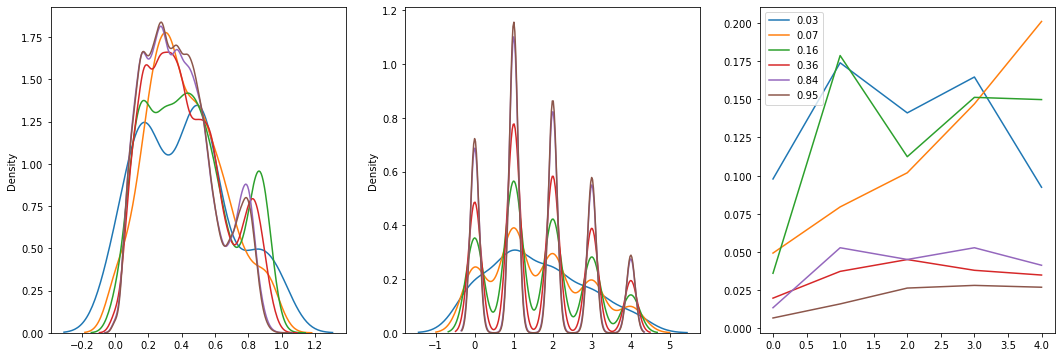

In [5]:
%matplotlib inline
## video pc
Pc = np.round(0.03 * 2 ** np.arange(0, 5, 0.3), 2)#np.round(0.01 * 2 ** np.arange(0, 6.7, 0.34), 3) # np.round(0.03 * 2 ** np.arange(0, 5, 0.3), 2)
# Pc = np.array(0.05)
Pc = Pc[::4]
Pvar = Pc = Pc[Pc > 6/traj.ncells]
Pvar = Pc = list(Pc) + [0.95]
Pt = Pconst = np.ones_like(Pvar)

res_pc = []
res_path_max_dist = {}
res_nearest_neighbor = {}

ncols = 3
fig,ax = plt.subplots(1,ncols,figsize=(6*ncols,6))
est_err_list = []
for pt,pc in zip(Pt, Pc):
    # sX, _, _, _, _, ix = traj.subsample(pc,pt)
    sX, psX, psD, sD, psP, ix = traj.subsample(pc,pt)
    
    # ix[0] = 0
    # sX.iloc[0] = traj.X.iloc[0]

    # ix[-1] = traj.ncells - 2
    # sX.iloc[-1] = traj.X.iloc[-1]

    # psX = traj.preprocess(sX)

    D, P = T.ds.get_pairwise_distances(psX, return_predecessors=True, verbose=True, plot=False)
    
    dmax_psD = np.max(psD); npsD = psD / dmax_psD
    dmax_sD = np.max(sD); nsD = sD / dmax_sD

    # compute error
    l1, l2, l3, lsp = T.ds.compare_distances(npsD, nsD)
    l_contrac = (sD / psD)[np.triu_indices_from(sD, 1)]
    l_expand = (psD / sD)[np.triu_indices_from(sD, 1)]
    l_distortion = np.mean(np.maximum(l_contrac,l_expand))
    # lr = np.abs(nsD - npsD)[np.triu_indices_from(sD, 1)]
    # sns.distplot(lr, label=pc, hist=False, ax=ax)

    # plt.title(f'Ratio error d_S / d_G : {np.mean(lr)}')
    # src = 0
    # des = sX.shape[0]-1
    src,des = np.unravel_index(D.argmax(), D.shape)
    path_max_dist = get_path(src, des, P)
    res_path_max_dist[pc] = path_max_dist
    
    df = psX.copy() #pd.DataFrame(psX[:,:2], columns=['pc0', 'pc1'])
    df['pc'] = pc
    df['pt'] = pt
    df['idx_c'] = ix
    df['idx'] = np.arange(len(ix))
    df['l1'] = l1
    res_pc.append(df)
    # break
    sns.distplot(nsD.flatten(), label=pc, hist=False, ax=ax[0])
    
    k = 5 # number of prosstt clusters
    nk = int(pc * traj.ncells / k)
    # nsD_pred = k * nk**2
    nsD_pred = np.repeat(np.arange(k,-1,-1), np.arange(k+1) * nk**2)
    nsD_pred = np.concatenate((nsD_pred, nsD_pred[:-k*nk**2]))
    # nsD_pred = np.concatenate((nsD_pred, np.zeros(nk)))
    sns.distplot(nsD_pred, label=pc, hist=False, ax=ax[1])

    # plot error
    bins = 5
    lr = np.abs(nsD - npsD)#[np.triu_indices_from(sD, 1)]
    tmp = pd.DataFrame({'org dists': nsD.flatten(), 'l1': lr.flatten()})
    tmp['org dists cut'] = pd.cut(tmp['org dists'], bins=bins, labels=np.arange(bins))
    avg_err = tmp.groupby('org dists cut')['l1'].mean()
    ax[2].plot(avg_err.index, avg_err.values, label=pc)


    # # estimate error per gap
    # dmax0 = np.max(traj.D)
    # R = 0.3
    # dmax = dmax0 = np.pi * R
    # alpha = pc * np.arange(k) / k * np.pi
    # d0_per_hop = alpha * R
    # d_per_hop = (1-alpha**2/(24*R**2))*alpha
    # err_per_hop = np.abs(d0_per_hop/dmax0 - d_per_hop/dmax)
    # ax[3].plot(avg_err.index, err_per_hop, label=pc)

    # does quantizing work?
    bins = 5
    ind = np.triu_indices_from(sD, 1)
    l_contrac = sD[ind] / psD[ind]
    l_expand = psD[ind] / sD[ind]
    lr = np.maximum(l_contrac,l_expand)
    l_distortion = np.mean(np.maximum(l_contrac,l_expand))
    

    # lr = np.abs(nsD - npsD)#[np.triu_indices_from(sD, 1)]
    emp_err = lr.mean()
    print(f'Empirical error: {emp_err}')
    tmp = pd.DataFrame({'org dists': nsD[ind], 'l1': lr})
    # tmp = pd.DataFrame({'org dists': nsD.flatten(), 'l1': lr.flatten()})
    tmp['org dists cut'] = pd.cut(tmp['org dists'], bins=bins, labels=np.arange(bins))
    tmp_grp_err = tmp.groupby('org dists cut')['l1']
    avg_err = pd.DataFrame(tmp_grp_err.mean())
    avg_err['counts'] = tmp_grp_err.size()
    quantized_err = (avg_err['l1'] * avg_err['counts']).sum() / sD.shape[0]**2
    print(f'Quantized error: {quantized_err}')

    # substituting just the distance distribution
    avg_err['pred counts'] = pd.DataFrame(nsD_pred).groupby(0).size()
    model_dist_err = (avg_err['l1'] * avg_err['pred counts']).sum() / sD.shape[0]**2
    print(f'Error computed with modeled distance distribution: {model_dist_err}')
    
    est_err_list.append({'pc': pc, 'emp_err': emp_err, 'quantized_err':quantized_err, 'model_dist_err': model_dist_err,'distortion_err': l_distortion })


plt.legend()
plt.show()
# plt.title(dataset)

    # A = kneighbors_graph(psX, 8, mode='distance', metric='euclidean', include_self=True)
    # G = nx.from_numpy_matrix(A.todense()>0)
    # pos = nx.spring_layout(G)
    # edge_weight = list(nx.get_edge_attributes(G,'weight').values())

    # pos = {}
    # for inode,node in enumerate(G.nodes()):
    #     pos[node] = psX.iloc[inode].values
    # nx.draw(G,pos, width=edge_weight, node_size=3)
    # plt.show()
df_pc = pd.concat(res_pc)

Text(0.5, 1.0, 'distortion_err')

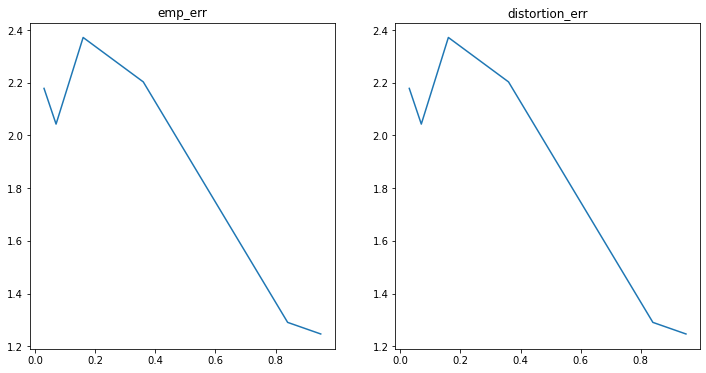

In [8]:
est_err = pd.DataFrame(est_err_list)
est_err['log pc'] = np.log(est_err['pc'])
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(est_err['pc'], est_err['emp_err']); ax[0].set_title('emp_err')
ax[1].plot(est_err['pc'], est_err['distortion_err']); ax[1].set_title('distortion_err')
# plt.plot(est_err['log pc'], est_err['quantized_err'])
# plt.plot(est_err['log pc'], est_err['model_dist_err'])

In [10]:
psX

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
cell_810,-12.137667,5.681416,1.306880,1.629276,-3.558084,1.980930,-0.818114,0.065251,1.627023,0.131514
cell_579,-3.816140,-8.770677,-3.245039,-2.459989,-1.045676,-1.383292,0.357049,-1.659040,-0.390050,1.737636
cell_272,5.057270,-1.897595,-0.024832,6.509888,-0.836547,0.308304,1.072469,0.676209,0.468929,-1.239263
cell_383,5.158901,-2.501465,1.607881,6.760482,2.320594,-2.316634,-3.836754,-0.456047,0.693696,-1.029645
cell_845,-12.289464,7.582033,-2.124172,0.587267,-2.449100,1.613409,-0.925782,-0.772922,0.583016,-0.965535
...,...,...,...,...,...,...,...,...,...,...
cell_78,21.674406,3.424086,0.914896,-3.822174,0.089615,0.284001,0.830837,0.432889,-1.078480,0.927491
cell_343,6.629413,-1.087608,1.278566,6.752542,2.074058,-0.274210,0.637927,-0.754913,-0.708971,1.567504
cell_662,-11.834786,-1.215375,6.325539,-3.124300,0.631062,0.146234,-0.001245,1.541851,-1.557630,-2.349242
cell_57,20.507181,1.685195,0.228394,-3.479096,0.898309,-0.382705,0.432004,-1.066917,-2.030550,1.294189


In [131]:
# does quantizing work?
bins = 5
lr = np.abs(nsD - npsD)#[np.triu_indices_from(sD, 1)]
print(f'Empirical error: {lr.mean()}')
tmp = pd.DataFrame({'org dists': nsD.flatten(), 'l1': lr.flatten()})
tmp['org dists cut'] = pd.cut(tmp['org dists'], bins=bins, labels=np.arange(bins))
tmp_grp_err = tmp.groupby('org dists cut')['l1']
avg_err = pd.DataFrame(tmp_grp_err.mean())
avg_err['counts'] = tmp_grp_err.size()
quantized_err = (avg_err['l1'] * avg_err['counts']).sum() / sD.shape[0]**2
print(f'Quantized error: {quantized_err}')

# substituting just the distance distribution
avg_err['pred counts'] = pd.DataFrame(nsD_pred).groupby(0).size()
model_dist_err = (avg_err['l1'] * avg_err['pred counts']).sum() / sD.shape[0]**2
print(f'Error computed with modeled distance distribution: {model_dist_err}')


Empirical error: 0.007834313872125544
Quantized error: 0.007834313872125544
Error computed with modeled distance distribution: 0.008174070251029154


In [129]:
# avg_err['pred counts'] = pd.DataFrame(nsD_pred).value_counts().loc[avg_err.index]


1    288800
2    216600
0    180500
3    144400
4     72200
Name: 0, dtype: int64
1    269894
0    236098
2    188592
3    135774
4     72142
Name: org dists cut, dtype: int64


/cs/usr/nomoriel/miniconda3/envs/traj/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/cs/usr/nomoriel/miniconda3/envs/traj/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

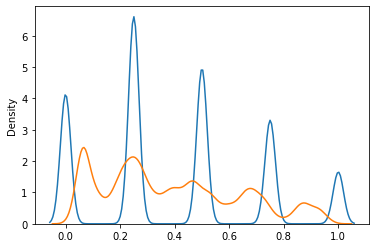

In [88]:
print(pd.DataFrame(nsD_pred)[0].value_counts())
print(tmp['org dists cut'].value_counts())
sns.distplot(nsD_pred / (nsD_pred.max()), label=pc, hist=False)
sns.distplot(nsD, label=pc, hist=False)
# sns.distplot(tmp['org dists cut'], label=pc, hist=False)

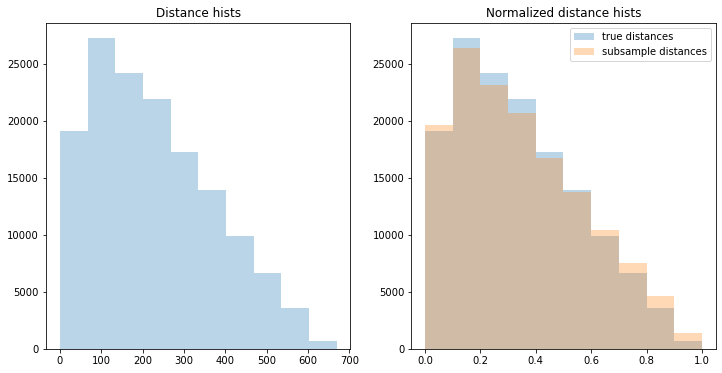

In [5]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].hist(sD.flatten(), alpha=0.3, label='true distances')
# ax[0].hist(psD.flatten(), alpha=0.3, label='subsample distances'); 
ax[0].set_title('Distance hists')

ax[1].hist(nsD.flatten(), alpha=0.3, label='true distances')
ax[1].hist(npsD.flatten(), alpha=0.3, label='subsample distances'); 
ax[1].set_title('Normalized distance hists')
plt.legend()

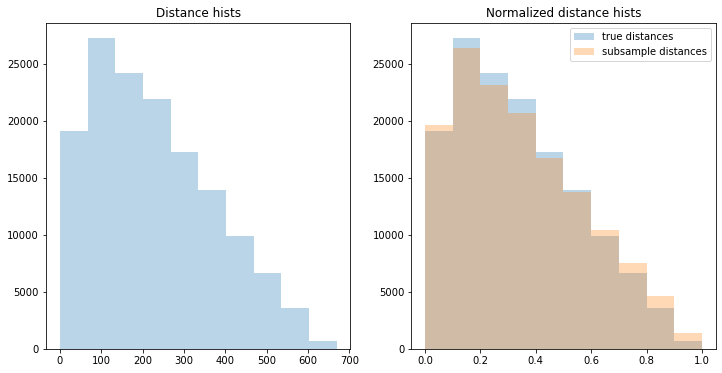

In [6]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].hist(sD.flatten(), alpha=0.3, label='true distances')
# ax[0].hist(psD.flatten(), alpha=0.3, label='subsample distances'); 
ax[0].set_title('Distance hists')

ax[1].hist(nsD.flatten(), alpha=0.3, label='true distances')
ax[1].hist(npsD.flatten(), alpha=0.3, label='subsample distances'); 
ax[1].set_title('Normalized distance hists')
plt.legend()

In [11]:
ix_sorted = np.argsort(ix)
D0 = nsD[ix_sorted][:,ix_sorted]
D1 = npsD[ix_sorted][:,ix_sorted]

l1: 0.02274811021389667, l1_mean: 0.022748110213896684, l1_mean_updiag: 0.02280813161287795


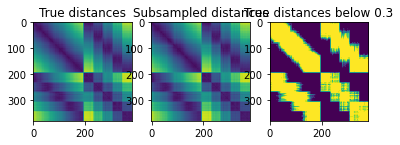

In [12]:
fig,ax = plt.subplots(1,3, figsize=(6,12))
thr = 0.3
ax[0].imshow(D0); ax[0].set_title('True distances')
ax[1].imshow(D1);ax[1].set_title('Subsampled distances')
ax[2].imshow(D0 < thr); ax[2].set_title(f'True distances below {thr}')
l1 = sum(sum(np.abs(np.array(D0) - np.array(D1)))) / len(D0) ** 2
l1_mean = np.mean(np.abs(D0-D1))
l1_mean_updiag = np.mean(np.abs(D0-D1)[np.triu_indices_from(D0, k=1)])
# l1 = round(sum(sum(np.log(np.array(D0)/ np.array(D1)))) / len(D0) ** 2, 3)
print(f'l1: {l1}, l1_mean: {l1_mean}, l1_mean_updiag: {l1_mean_updiag}')

Text(0.5, 1.0, 'Avg error per true distance range')

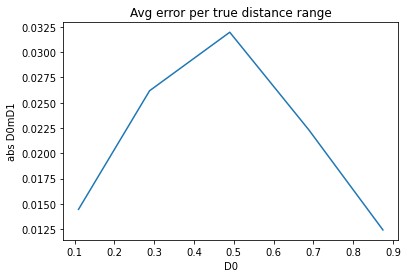

In [13]:
tmp = pd.DataFrame({'D0': D0.flatten(), 'D1': D1.flatten()})
tmp['D0mD1'] = tmp['D0'] - tmp['D1']
tmp['abs D0mD1'] = tmp['D0mD1'].abs()
tmp['D0overD1'] = tmp['D0'] / tmp['D1']
tmp['log D0overD1'] = np.log(tmp['D0overD1'])
tmp['abs D0overD1'] = tmp['log D0overD1'].abs()

tmp['D0bin'] = pd.cut(tmp['D0'], bins=5)
grp = tmp.groupby('D0bin').mean()
xcol = 'D0'
ycol = 'abs D0mD1'
plt.plot(grp[xcol], grp[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)
plt.title('Avg error per true distance range')

In [ ]:
# # L2 = traj.compute_tradeoff(B=-1, Pc=Pc, Pt=Pt, repeats=20)
# xcol = 'log pc'
# ycol = 'l1'
# fig,ax = plt.subplots(1, 1, figsize=(6,6))
# T.pl.plot_tradeoff(L, xcol=xcol, xlabel=xcol, ycol=ycol, ylabel=ycol, ax=ax)
# T.pl.plot_tradeoff(L2, xcol=xcol, xlabel=xcol, ycol=ycol, ylabel=ycol, ax=ax, color_mean='red', color_std='red')
# # fig.savefig(f'{dataset}_pc_err.png')
# # ax.set_ylim(0)

In [ ]:
col0 = df.columns[0]
col1 = df.columns[1]
# xlim = (df_pc[col0].min(), df_pc[col0].max())
# ylim = (df_pc[col1].min(), df_pc[col1].max())

@gif.frame
def plot(j):
    i = len(Pt) - 1 - j
    i = len(Pc) - 1 - j
    sdf_pc = df_pc[(df_pc['pc'] == Pc[i])]
    plt.scatter(sdf_pc[col0], sdf_pc[col1], c= sdf_pc['idx_c'], cmap='rainbow')
    # plt.scatter(sdf_pc.iloc[[0,-1]][col0], sdf_pc.iloc[[0,-1]][col1], c='b')
    
    sdf_pc.index = sdf_pc['idx']
    sdf = sdf_pc.loc[res_path_max_dist[Pc[i]]]
    sdf['path_idx'] = np.arange(sdf.shape[0])
    plt.plot(sdf[col0], sdf[col1], c='r')
    plt.title(fr'log $p_c$={np.round(np.log(Pc[i]), 2)}')
    plt.axis('off')
    # plt.xlim(xlim)
    # plt.ylim(ylim)
    
frames = []
for j in range(len(Pc)):
    frame = plot(j)
    frames.append(frame)

# gif.save(frames, f'{dataset}_pc_constant_size.gif', duration=10, unit="s", between="startend")
gif.save(frames, f'{dataset}_pc.gif', duration=10, unit="s", between="startend")



In [8]:
# Pc = np.round(0.03 * 2 ** np.arange(0, 5, 0.3), 2)#np.round(0.01 * 2 ** np.arange(0, 6.7, 0.34), 3) # np.round(0.03 * 2 ** np.arange(0, 5, 0.3), 2)
Pc = np.array([0.05, 0.1, 0.15])
# Pc = Pc[::4]
# Pvar = Pc = Pc[Pc > 6/traj.ncells]
Pvar = Pc = list(Pc) + [0.95]
Pt = Pconst = np.ones_like(Pvar)


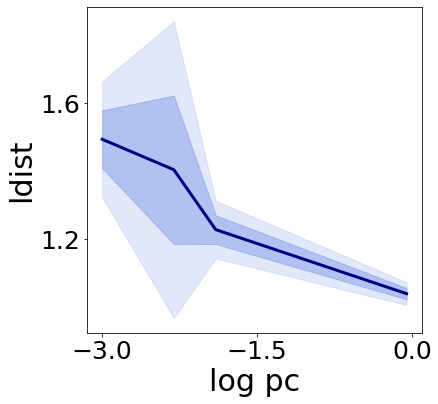

In [10]:
# L = traj.compute_tradeoff(B=-1, Pc=Pc, Pt=Pt, repeats=3)
# d = 4
# L['pc inv pow'] = 1 / L['pc']**(1/d)
xcol = 'log pc' #'pc' #'pc' #'pc inv pow'# 'log pc'
ycol = 'ldist'
fig,ax = plt.subplots(1, 1, figsize=(6,6))
T.pl.plot_tradeoff(L, xcol=xcol, xlabel=xcol, ycol=ycol, ylabel=ycol, ax=ax);
# fig.savefig(f'{dataset}_pc_err.png')
# ax.set_ylim(0)

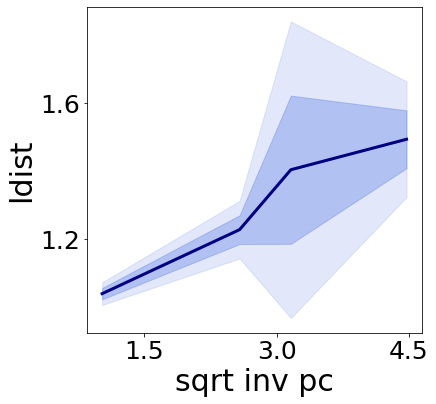

In [12]:
L['sqrt inv pc'] = np.sqrt(1/L['pc'])
xcol = 'sqrt inv pc'
T.pl.plot_tradeoff(L, xcol=xcol, xlabel=xcol, ycol=ycol, ylabel=ycol);

In [16]:
# np.round(0.01 * 2 ** np.arange(0, 6.7, 0.34), 3)
# 10 ** np.linspace(-5, -1, 10)
np.arange(0.03, 0.6, 0.01) #TEMP

array([0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13,
       0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24,
       0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35,
       0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46,
       0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57,
       0.58, 0.59])

In [ ]:
# # L = traj.compute_tradeoff(B=-1, Pc=Pc, Pt=Pt, repeats=20)
# xcol = 'pc inv to power'#'log pc'
# ycol = 'l1'
# # fig,ax = plt.subplots(1, 1, figsize=(6,6))
# L[xcol] = (1 / L['nc'])**(1/2) 
# T.pl.plot_tradeoff(L, xcol=xcol, xlabel=xcol, ycol=ycol, ylabel=ycol, title='d=2');plt.show()
# L[xcol] = (1 / L['nc'])**(1/20) 
# T.pl.plot_tradeoff(L, xcol=xcol, xlabel=xcol, ycol=ycol, ylabel=ycol, title='d=20'); 
# # fig.savefig(f'{dataset}_pc_err.png')
# # ax.set_ylim(0)

In [ ]:
for i in np.arange(2,10):
    pc = 'PC%d' % i
    T.pl.plot_pca2d(traj.pX[['PC1', pc]], traj.meta, color='milestone_id')
    # plt.scatter(traj.pX[['PC1']], traj.pX[[pc]]); 
    # plt.xlabel('PC1')
    # plt.ylabel(pc)
    plt.show()

In [ ]:
fig.savefig(f'{dataset}_pc_err.png')

In [ ]:
# kwargs0 = {'axis': alt.Axis(grid=False)}
# kwargs1 = {'axis': alt.Axis(grid=False)}
# kwargs0['scale'] = alt.Scale(domain=[df['pc0'].min(), df['pc0'].max()])
# kwargs1['scale'] = alt.Scale(domain=[df['pc1'].min(), df['pc1'].max()])
# kwargsc = {'width':800, 'height':400}
                     
    
# def demo(j):
#     i = len(Pc) - 1 - j
#     sdf_pc = df_pc[(df_pc['pc'] == Pc[i])]
#     pl_pt = alt.Chart(sdf_pc, **kwargsc).mark_circle().encode(x=alt.X('pc0:Q',**kwargs0), 
#                                                 y=alt.Y('pc1:Q',**kwargs1), 
#                                                 color=alt.Color('idx_c:O', 
#                                                                 legend=None, scale=alt.Scale(scheme='rainbow')))
#     pl_pt0 = alt.Chart(sdf_pc.iloc[[0,-1]], **kwargsc).mark_circle().encode(x=alt.X('pc0:Q',**kwargs0), 
#                                                 y=alt.Y('pc1:Q',**kwargs1), 
#                                                 color=alt.value('black'))

#     sdf_pc.index = sdf_pc['idx']
#     sdf = sdf_pc.loc[res_path[Pc[i]]]
#     sdf['path_idx'] = np.arange(sdf.shape[0])
#     pl_path = alt.Chart(sdf, **kwargsc).mark_line().encode(x=alt.X('pc0:Q', **kwargs0), 
#                                                 y=alt.Y('pc1:Q', **kwargs1),
#                                                 order='path_idx', color=alt.value('red'))
#     return pl_pt + pl_pt0 +pl_path


# interact(demo, j = widgets.Play(
#     value=0,
#     min=0,
#     max=len(Pc)-1,
#     step=1,
#     description="Press play",
    
#     disabled=False))

# r = 10
# nr = 10**np.linspace(1,3,50)
# B = r * nr*np.log(nr)
# nc = B/nr

# plt.scatter(B, nc)

## tradeoff

In [ ]:
## video tradeoff
B = 0.0016681005372
Pc = Pvar = np.arange(0.03, 0.9, 0.03)


res_tradeoff = []
for pc in Pc:
    # for r in np.arange(repeat):
    pt = B/pc
    sX, psX, psD, sD, psP, ix = traj.subsample(pc,pt)

    df = pd.DataFrame(psX[:,:2], columns=['pc0', 'pc1'])
    df['pc'] = pc
    df['pt'] = pt
    df['idx_c'] = ix
    df['idx'] = np.arange(len(ix))
    res_tradeoff.append(df)

In [ ]:
df_tradeoff = pd.concat(res_tradeoff)
# xlim = (df_tradeoff['pc0'].min(), df_tradeoff['pc0'].max())
# ylim = (df_tradeoff['pc1'].min(), df_tradeoff['pc1'].max())

@gif.frame
def plot(j):
    i = len(Pc) - 1 - j
    sdf_tradeoff = df_tradeoff[(df_tradeoff['pc'] == Pc[i])]
    plt.scatter(sdf_tradeoff['pc0'], sdf_tradeoff['pc1'], c= sdf_tradeoff['idx_c'], cmap='rainbow')
    # plt.scatter(sdf_tradeoff.iloc[[0,-1]]['pc0'], sdf_tradeoff.iloc[[0,-1]]['pc1'], c='b')
    
    # sdf_tradeoff.index = sdf_tradeoff['idx']
    # sdf = sdf_tradeoff.loc[res_path_max_dist[Pc[i]]]
    # sdf['path_idx'] = np.arange(sdf.shape[0])
    # plt.plot(sdf['pc0'], sdf['pc1'], c='r')
    plt.title(fr'$p_c$={np.round(Pc[i], 3)}')
    # plt.title(fr'log $p_c$={np.round(np.log(Pc[i]), 2)}')
    plt.axis('off')
    # plt.xlim(xlim)
    # plt.ylim(ylim)
    
frames = []
for j in range(len(Pc)):
    frame = plot(j)
    frames.append(frame)

gif.save(frames, f'{dataset}_tradeoff.gif', duration=20, unit="s", between="startend")
# gif.save(frames, f'{dataset}_pc.gif', duration=10, unit="s", between="startend")

